<a href="https://colab.research.google.com/github/DietzscheNostoevsky/Learning_Pytorch/blob/main/06_Pytorch_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Take a computer vision model pretrained on ImageNet and try to leverage its underlying learned representations for classifying images of pizza, steak and sushi.

# 0. Setup 


Importing required modules and files.  
Using going_modular directory functions.  



In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [3]:
# Device Agnostic Code 

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
import os 
import zipfile 
from pathlib import Path
import requests 
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# 1. Getting Data 

## Small 150 Dataset

In [5]:
import os 
import zipfile 
from pathlib import Path
import requests 

# Setup path to data folder 

data_path = Path("data/") # The trailing forward slash (/) in the string 
                          # is used to indicate that it represents a 
                          # directory rather than a specific file. 
                          # It's a common convention to include the trailing slash 
                          # in directory paths to differentiate them from file paths.

image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")


data/pizza_steak_sushi directory exists.


In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


## Getting larger dataset from Drive

In [7]:
# Mount the GDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data_path = Path("data/") # The trailing forward slash (/) in the string 
                          # is used to indicate that it represents a 
                          # directory rather than a specific file. 
                          # It's a common convention to include the trailing slash 
                          # in directory paths to differentiate them from file paths.

image_path_full = data_path / "pizza_steak_sushi_full"

if image_path.is_dir():
    print(f"{image_path_full} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path_full.mkdir(parents=True, exist_ok=True)
zip_data = "/content/drive/Othercomputers/My MacBook Air/GitHub/-Machine_Learning/Learning_Pytorch/pizza_steak_sushi_100_percent.zip"

with zipfile.ZipFile(zip_data, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path_full)
walk_through_dir(image_path_full)

data/pizza_steak_sushi_full directory exists.
Unzipping pizza, steak, sushi data...
There are 2 directories and 0 images in 'data/pizza_steak_sushi_full'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_full/test'.
There are 0 directories and 250 images in 'data/pizza_steak_sushi_full/test/steak'.
There are 0 directories and 250 images in 'data/pizza_steak_sushi_full/test/sushi'.
There are 0 directories and 250 images in 'data/pizza_steak_sushi_full/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_full/train'.
There are 0 directories and 750 images in 'data/pizza_steak_sushi_full/train/steak'.
There are 0 directories and 750 images in 'data/pizza_steak_sushi_full/train/sushi'.
There are 0 directories and 750 images in 'data/pizza_steak_sushi_full/train/pizza'.


In [9]:
walk_through_dir(image_path_full)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_full'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_full/test'.
There are 0 directories and 250 images in 'data/pizza_steak_sushi_full/test/steak'.
There are 0 directories and 250 images in 'data/pizza_steak_sushi_full/test/sushi'.
There are 0 directories and 250 images in 'data/pizza_steak_sushi_full/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_full/train'.
There are 0 directories and 750 images in 'data/pizza_steak_sushi_full/train/steak'.
There are 0 directories and 750 images in 'data/pizza_steak_sushi_full/train/sushi'.
There are 0 directories and 750 images in 'data/pizza_steak_sushi_full/train/pizza'.


# 2. Creating Datasets and DataLoaders

In [10]:
# Setup Dirs
# small dataset
#train_dir = image_path / "train"
#test_dir = image_path / "test"

#full dataset
train_dir = image_path_full / "train"
test_dir = image_path_full / "test"

## 2.1 Creating a transform for torchvision.models (manual creation)

> **Note:** As of `torchvision` v0.13+, there's an update to how data transforms can be created using `torchvision.models`. I've called the previous method "manual creation" and the new method "auto creation". This notebook showcases both.

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

> **Question:** *Where did the mean and standard deviation values come from? Why do we need to do this?*
>
> These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.
>
> We also don't *need* to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.

Prior to `torchvision` v0.13+, to create a transform for a pretrained model in `torchvision.models`, the documentation stated:

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. 
>
> The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. 
>
> You can use the following transform to normalize:
>
> ```
> normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
>                                  std=[0.229, 0.224, 0.225])
> ```


In [11]:
# Manually creating transform pipeline 

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [12]:
# Creating Dataloaders
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f3ca2f57880>,
 ['pizza', 'steak', 'sushi'])

In [13]:
len(train_dataloader.dataset)
len(test_dataloader.dataset)

750

 ## 2.2 Creating a transform for torchvision.models (auto creation)

In [14]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [15]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [16]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f3ca2f57f10>,
 ['pizza', 'steak', 'sushi'])

In [17]:
print(len(train_dataloader.dataset))
print(len(test_dataloader.dataset))

2250
750


# 3. Getting Pretrained Model

### 3.2 Setting up a pretrained model

The pretrained model we're going to be using is [`torchvision.models.efficientnet_b0()`](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html).

The architecture is from the paper *[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)*.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-effnet-b0-feature-extractor.png" alt="efficienet_b0 from PyTorch torchvision feature extraction model" width=900/>

*Example of what we're going to create, a pretrained [`EfficientNet_B0` model](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html) from `torchvision.models` with the output layer adjusted for our use case of classifying pizza, steak and sushi images.*

We can setup the `EfficientNet_B0` pretrained ImageNet weights using the same code as we used to create the transforms.

In [18]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)


In [19]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

If we print the model, we get something similar to the following:

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnetb0-model-print-out.png" alt="output of printing the efficientnet_b0 model from torchvision.models" width=900/>

 `efficientnet_b0` comes in three main parts:
1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as **features** or **feature extractor**, "the base layers of the model learn the different **features** of images").
2. `avgpool` - Takes the average of the output of the `features` layer(s) and turns it into a **feature vector**.
3. `classifier` - Turns the **feature vector** into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on ImageNet and because ImageNet has 1000 classes, `out_features=1000` is the default). 

## Getting model summary


To learn more about our model, let's use `torchinfo`'s [`summary()` method](https://github.com/TylerYep/torchinfo#documentation).

To do so, we'll pass in:
 * `model` - the model we'd like to get a summary of.
 * `input_size` - the shape of the data we'd like to pass to our model, for the case of `efficientnet_b0`, the input size is `(batch_size, 3, 224, 224)`, though [other variants of `efficientnet_bX` have different input sizes](https://github.com/pytorch/vision/blob/d2bfd639e46e1c5dc3c177f889dc7750c8d137c7/references/classification/train.py#L92-L93).
    * **Note:** Many modern models can handle input images of varying sizes thanks to [`torch.nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html), this layer adaptively adjusts the `output_size` of a given input as required. You can try this out by passing different size input images to `summary()` or your models.
 * `col_names` - the various information columns we'd like to see about our model. 
 * `col_width` - how wide the columns should be for the summary.
 * `row_settings` - what features to show in a row.

In [20]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        #col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the `features` section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnet-changing-the-classifier-head.png" alt="changing the efficientnet classifier head to a custom number of outputs" width=900/>

*You can customise the outputs of a pretrained model by changing the output layer(s) to suit your problem. The original `torchvision.models.efficientnet_b0()` comes with `out_features=1000` because there are 1000 classes in ImageNet, the dataset it was trained on. However, for our problem, classifying images of pizza, steak and sushi we only need `out_features=3`.*

Let's freeze all of the layers/parameters in the `features` section of our `efficientnet_b0` model.

> **Note:** To *freeze* layers means to keep them how they are during training. For example, if your model has pretrained layers, to *freeze* them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

**In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.**

In [21]:
# # Freeze all base layers in the "features" section of the model 
# (the feature extractor) by setting requires_grad=False

for param in model.features.parameters():
    param.requires_grad = False


Feature extractor layers frozen!

Let's now adjust the output layer or the `classifier` portion of our pretrained model to our needs.

Right now our pretrained model has `out_features=1000` because there are 1000 classes in ImageNet. 

However, we don't have 1000 classes, we only have three, pizza, steak and sushi.

We can change the `classifier` portion of our model by creating a new series of layers.

The current `classifier` consists of:

```
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
```

We'll keep the `Dropout` layer the same using [`torch.nn.Dropout(p=0.2, inplace=True)`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

> **Note:** [Dropout layers](https://developers.google.com/machine-learning/glossary#dropout_regularization) randomly remove connections between two neural network layers with a probability of `p`. For example, if `p=0.2`, 20% of connections between neural network layers will be removed at random each pass. This practice is meant to help regularize (prevent overfitting) a model by making sure the connections that remain learn features to compensate for the removal of the other connections (hopefully these remaining features are *more general*). 

And we'll keep `in_features=1280` for our `Linear` output layer but we'll change the `out_features` value to the length of our `class_names` (`len(['pizza', 'steak', 'sushi']) = 3`).

Our new `classifier` layer should be on the same device as our `model`. 

In [22]:
# Setting manual seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and send it to the target device

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)



In [23]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-torchinfo-summary-frozen-layers.png" alt="output of torchinfo.summary() after freezing multiple layers in our model and changing the classifier head" width=900/>

**changes**

Let's go through them:
* **Trainable column** - You'll see that many of the base layers (the ones in the `features` portion) have their Trainable value as `False`. This is because we set their attribute `requires_grad=False`. Unless we change this, these layers won't be updated during furture training.
* **Output shape of `classifier`** - The `classifier` portion of the model now has an Output Shape value of `[32, 3]` instead of `[32, 1000]`. It's Trainable value is also `True`. This means its parameters will be updated during training. In essence, we're using the `features` portion to feed our `classifier` portion a base representation of an image and then our `classifier` layer is going to learn how to base representation aligns with our problem.
* **Less trainable parameters** - Previously there was 5,288,548 trainable parameters. But since we froze many of the layers of the model and only left the `classifier` as trainable, there's now only 3,843 trainable parameters (even less than our TinyVGG model). Though there's also 4,007,548 non-trainable parameters, these will create a base representation of our input images to feed into our `classifier` layer.

> **Note:** The more trainable parameters a model has, the more compute power/longer it takes to train. Freezing the base layers of our model and leaving it with less trainable parameters means our model should train quite quickly. This is one huge benefit of transfer learning, taking the already learned parameters of a model trained on a problem similar to yours and only tweaking the outputs slightly to suit your problem.

# 4. Training Model

In [24]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6575 | train_acc: 0.7675 | test_loss: 0.3340 | test_acc: 0.9115
Epoch: 2 | train_loss: 0.4056 | train_acc: 0.8714 | test_loss: 0.2575 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.3321 | train_acc: 0.8911 | test_loss: 0.2167 | test_acc: 0.9336
Epoch: 4 | train_loss: 0.2900 | train_acc: 0.9089 | test_loss: 0.1940 | test_acc: 0.9414
Epoch: 5 | train_loss: 0.2916 | train_acc: 0.8958 | test_loss: 0.1873 | test_acc: 0.9453
Epoch: 6 | train_loss: 0.2627 | train_acc: 0.9031 | test_loss: 0.1819 | test_acc: 0.9453
Epoch: 7 | train_loss: 0.2584 | train_acc: 0.9106 | test_loss: 0.1747 | test_acc: 0.9449
Epoch: 8 | train_loss: 0.2419 | train_acc: 0.9127 | test_loss: 0.1722 | test_acc: 0.9492
Epoch: 9 | train_loss: 0.2394 | train_acc: 0.9141 | test_loss: 0.1645 | test_acc: 0.9505
Epoch: 10 | train_loss: 0.2137 | train_acc: 0.9281 | test_loss: 0.1613 | test_acc: 0.9492
Epoch: 11 | train_loss: 0.2227 | train_acc: 0.9238 | test_loss: 0.1601 | test_acc: 0.9518
Epoch: 12 | train_l

# 5. Model Evaluation using loss curves 

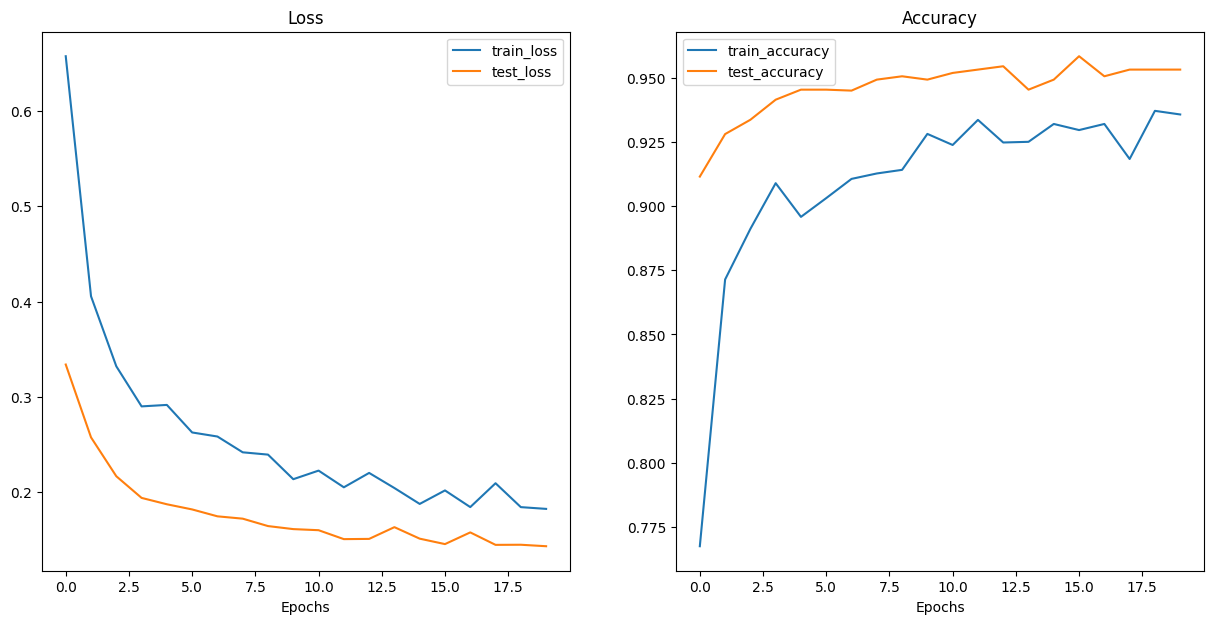

In [26]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

# 6. Making predictions in test set

Function to predict and plot

In [27]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

Testing on some random images 

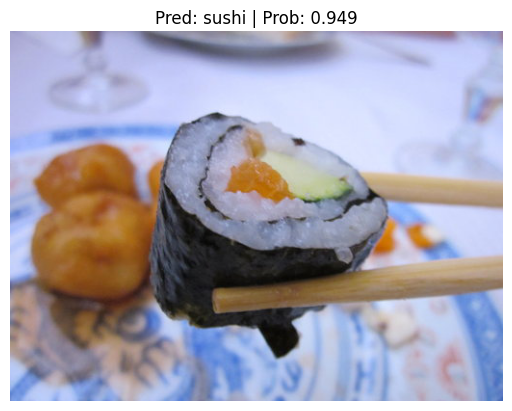

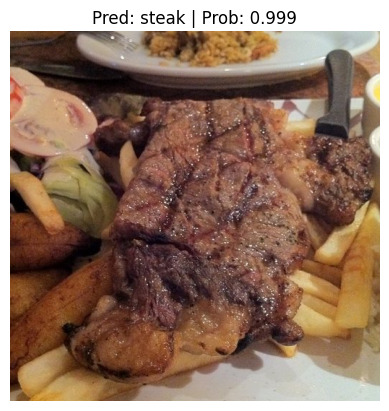

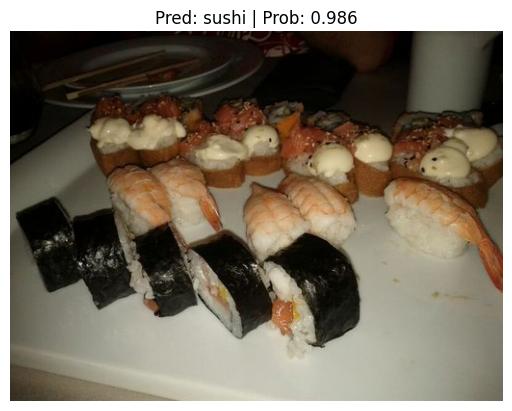

In [28]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

## Making prediction on a custom image 

data/04-pizza-dad.jpeg already exists, skipping download.


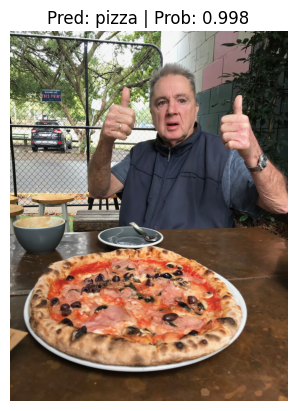

In [29]:

# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)